## **<font color='pink'>Opportunity Zones Project - Running Synthetic Models against All Data</font>**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
sns.set()  #if you want to use seaborn themes with matplotlib functions
import warnings
warnings.filterwarnings('ignore')
rand_state = 1000

In [2]:
df = pd.read_csv('thesis_clean.csv')
df.shape

(29754, 82)

In [3]:
df.head()

,DesignatedOZ,Type,SE_Flag,Population,medhhincome,PovertyRate,unemprate,medvalue,medrent,pctown,...,state_49.0,dec_score_2.0,dec_score_3.0,dec_score_4.0,dec_score_5.0,dec_score_6.0,dec_score_7.0,dec_score_8.0,dec_score_9.0,dec_score_10.0
0,1,0,0,29256,45770,0.07,0.09,24900,937,0.41,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,22748,80068,0.21,0.05,272800,1083,0.74,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,20092,49930,0.17,0.12,125100,993,0.55,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,19834,36756,0.24,0.15,115600,1118,0.55,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,19187,43750,0.17,0.06,150600,1079,0.48,...,0,0,0,0,0,0,1,0,0,0


In [4]:
pd.crosstab(df['DesignatedOZ'],df['DesignatedOZ'], normalize='all')*100

DesignatedOZ,0,1
DesignatedOZ,,
0,75.502453,0.000000
1,0.000000,24.497547


After cleaning the data, it looks like almost 25% of the eligible tracts were designated as opportunity zones. In terms of training the models, this is a relatively balanced split between designated and non-designated.

## **<font color='pink'>Training the Republican Model</font>**

Before training the model, we'll split the data into training and test.

In [5]:
df_repub = df.query('repubstate =="1"')

In [6]:
df_repub.shape

(17809, 82)

In [7]:
y_repub = df_repub['DesignatedOZ']
X_repub = df_repub.drop(['DesignatedOZ'], axis=1) # becareful inplace= False

from sklearn.model_selection import train_test_split
X_repub_train, X_repub_test, y_repub_train, y_repub_test = train_test_split(X_repub, y_repub, test_size=0.3, random_state=rand_state)

In [9]:
X_repub_test.shape

(5343, 81)

In [10]:
pd.crosstab(df_repub['DesignatedOZ'],df['DesignatedOZ'], normalize='all')*100

DesignatedOZ,0,1
DesignatedOZ,,
0,75.400079,0.000000
1,0.000000,24.599921


Training/fitting the republican model:

In [11]:
%%time
# Fitting XGBoost classifier to the Training set
XGB_classifier_repub = XGBClassifier(random_state=rand_state, use_label_encoder=True)
XGB_classifier_repub.fit(X_repub_train, y_repub_train)

[09:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 4.02 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=1000, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Predicting the values of Y in the test data.

In [12]:
# Predicting the Test set probabilities and classes
repub_y_hat_XGB = XGB_classifier_repub.predict(X_repub_test)

Looking at those predictions against the true Y values in the test set to get our accuracy:

In [13]:
np.round(XGB_classifier_repub.score(X_repub_test, y_repub_test),4)

0.7672

In [14]:
print('XGB f1 = {}'.format(f1_score(y_repub_test, repub_y_hat_XGB)))

XGB f1 = 0.3627049180327868


In [15]:
confusion_matrix(y_repub_test, repub_y_hat_XGB)

array([[3745,  288],
       [ 956,  354]], dtype=int64)

In [16]:
#Getting the probability predictions:

In [17]:
repub_y_hat_XGB_proba = XGB_classifier_repub.predict_proba(X_repub_test)

In [18]:
print(repub_y_hat_XGB_proba)

[[0.95535177 0.04464824]
 [0.46407247 0.53592753]
 [0.58513683 0.41486317]
 ...
 [0.96917063 0.03082938]
 [0.76228994 0.23771006]
 [0.8968053  0.10319471]]


In [19]:
df_repub_test = pd.DataFrame(X_repub_test).copy()
df_repub_test['Designated_OZ'] = y_repub_test
df_repub_test['prob_0'] = repub_y_hat_XGB_proba[:,0] 
df_repub_test['prob_1'] = repub_y_hat_XGB_proba[:,1]
df_repub_test['Model_Designated_OZ'] = repub_y_hat_XGB

In [20]:
df_repub_test.shape

(5343, 85)

In [21]:
df_repub_test.head()

,Type,SE_Flag,Population,medhhincome,PovertyRate,unemprate,medvalue,medrent,pctown,severerentburden,...,dec_score_5.0,dec_score_6.0,dec_score_7.0,dec_score_8.0,dec_score_9.0,dec_score_10.0,Designated_OZ,prob_0,prob_1,Model_Designated_OZ
25814,0,0,2140,41042,0.10,0.11,81900,809,0.90,0.41,...,0,0,0,0,0,0,0,0.955352,0.044648,0
29149,0,0,1237,15750,0.65,0.14,94500,833,0.20,0.39,...,0,0,0,0,0,0,0,0.464072,0.535928,1
27267,0,0,1823,17425,0.45,0.18,78100,853,0.44,0.44,...,0,1,0,0,0,0,1,0.585137,0.414863,0
7883,0,0,5043,30670,0.64,0.16,139100,715,0.18,0.52,...,0,0,1,0,0,0,0,0.748705,0.251295,0
1320,0,0,7520,31408,0.37,0.10,75600,618,0.53,0.18,...,0,0,0,0,0,0,1,0.387674,0.612326,1


In [22]:
df_repub_test.to_csv('Repub_Model_Test.csv')

Let's take a look at the feature importance in the republican model.

In [23]:
import shap

In [24]:
from xgboost import XGBClassifier, plot_importance

In [25]:
sorted_idx = np.argsort(XGB_classifier_repub.feature_importances_)[::-1]

In [26]:
for index in sorted_idx:
    print([X_repub_train.columns[index], XGB_classifier_repub.feature_importances_[index]]) 

['state_8.0', 0.05575779]
['Metro', 0.04583134]
['state_42.0', 0.040626608]
['state_9.0', 0.04019352]
['state_12.0', 0.033720896]
['state_23.0', 0.02150247]
['dec_score_2.0', 0.021305693]
['unemprate', 0.019954138]
['state_24.0', 0.019946387]
['pctown', 0.019907841]
['state_30.0', 0.019563098]
['medhhincome', 0.019208064]
['dec_score_7.0', 0.017451633]
['state_49.0', 0.017375603]
['state_3.0', 0.016922152]
['PovertyRate', 0.016870845]
['dec_score_9.0', 0.016840022]
['state_21.0', 0.01668859]
['state_34.0', 0.016279168]
['state_19.0', 0.015798168]
['dec_score_5.0', 0.015507742]
['dec_score_4.0', 0.015240388]
['dec_score_8.0', 0.015198496]
['state_16.0', 0.015105434]
['state_33.0', 0.014910553]
['pctwhite', 0.014897687]
['vacancyrate', 0.0146820415]
['pctAAPIalone', 0.014628904]
['pctBlack', 0.0145737585]
['pctHispanic', 0.014554235]
['state_39.0', 0.0142137855]
['Population ', 0.014118142]
['state_40.0', 0.013891562]
['pctunder18', 0.013871267]
['BAorhigher', 0.013823506]
['state_13.0',

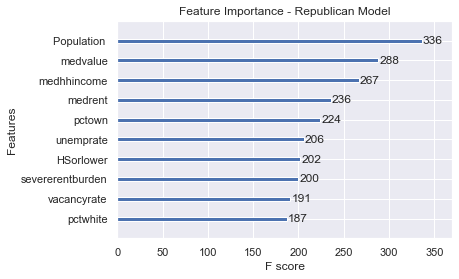

In [27]:
plot_importance(XGB_classifier_repub, max_num_features = 10, title='Feature Importance - Republican Model')
plt.show()

It looks like the republican model is focusing primarily on population, medvalue, medhhincome, and medrent when making predictions.

## **<font color='pink'>Synthetic Republicans: Running the Republican Model on Democrat State's Data</font>**

In [28]:
df_dem = df.query('repubstate =="0"')

In [29]:
df_dem.shape

(11945, 82)

In [30]:
y_dem = df_dem['DesignatedOZ']
X_dem = df_dem.drop(['DesignatedOZ'], axis=1) # becareful inplace= False

from sklearn.model_selection import train_test_split
X_dem_train, X_dem_test, y_dem_train, y_dem_test = train_test_split(X_dem, y_dem, test_size=0.3, random_state=rand_state)

In [31]:
synthrepub_y_hat_XGB = XGB_classifier_repub.predict(X_dem)

In [33]:
np.round(XGB_classifier_repub.score(X_dem, y_dem),4)

0.7518

In [35]:
print('XGB f1 = {}'.format(f1_score(y_dem, synthrepub_y_hat_XGB)))

XGB f1 = 0.19451236077152947


In [36]:
#Getting the probability predictions:

In [38]:
synth_repubXGB_proba = XGB_classifier_repub.predict_proba(X_dem)

In [39]:
print(synth_repubXGB_proba)

[[0.7267715  0.27322856]
 [0.89819896 0.10180106]
 [0.61201364 0.38798636]
 ...
 [0.93362534 0.06637468]
 [0.56794524 0.4320548 ]
 [0.5285083  0.47149166]]


In [40]:
df_synth_repubXGB_test = pd.DataFrame(X_dem).copy()
df_synth_repubXGB_test['Designated_OZ'] = y_dem
df_synth_repubXGB_test['prob_0'] = synth_repubXGB_proba[:,0] 
df_synth_repubXGB_test['prob_1'] = synth_repubXGB_proba[:,1]
df_synth_repubXGB_test['Model_Designated_OZ'] = synthrepub_y_hat_XGB

In [41]:
df_synth_repubXGB_test.shape

(11945, 85)

In [42]:
df_synth_repubXGB_test.head()

,Type,SE_Flag,Population,medhhincome,PovertyRate,unemprate,medvalue,medrent,pctown,severerentburden,...,dec_score_5.0,dec_score_6.0,dec_score_7.0,dec_score_8.0,dec_score_9.0,dec_score_10.0,Designated_OZ,prob_0,prob_1,Model_Designated_OZ
0,0,0,29256,45770,0.07,0.09,24900,937,0.41,0.21,...,0,0,0,0,0,0,1,0.726771,0.273229,0
1,0,0,22748,80068,0.21,0.05,272800,1083,0.74,0.30,...,0,0,0,0,1,0,1,0.898199,0.101801,0
7,0,0,17400,49172,0.18,0.10,144000,1107,0.60,0.28,...,0,0,0,1,0,0,0,0.612014,0.387986,0
10,0,0,16942,40305,0.45,0.06,400500,1330,0.26,0.37,...,0,0,0,0,0,0,0,0.986986,0.013014,0
11,0,0,16589,56019,0.15,0.09,151900,1079,0.76,0.15,...,0,0,0,0,0,0,0,0.697667,0.302333,0


In [43]:
df_synth_repubXGB_test.to_csv('Synth_Repub_Test_All_Dem_Data.csv')

Let's train another model on the data from the democrat states and see how it differs.

## **<font color='pink'>Training the Democrat Model</font>**

In [44]:
y_dem = df_dem['DesignatedOZ']
X_dem = df_dem.drop(['DesignatedOZ'], axis=1) # becareful inplace= False

from sklearn.model_selection import train_test_split
X_dem_train, X_dem_test, y_dem_train, y_dem_test = train_test_split(X_dem, y_dem, test_size=0.3, random_state=rand_state)

In [45]:
pd.crosstab(df_dem['DesignatedOZ'],df['DesignatedOZ'], normalize='all')*100

DesignatedOZ,0,1
DesignatedOZ,,
0,75.655086,0.000000
1,0.000000,24.344914


Still a relatively balanced 75/25 split! Let's train the model.

In [46]:
%%time
# Fitting XGBoost classifier to the Training set
XGB_classifier_dem = XGBClassifier(random_state=rand_state, use_label_encoder=True)
XGB_classifier_dem.fit(X_dem_train, y_dem_train)

[09:10:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2.85 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=1000, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [47]:
# Predicting the Test set probabilities and classes
dem_y_hat_XGB = XGB_classifier_dem.predict(X_dem_test)

In [48]:
np.round(XGB_classifier_dem.score(X_dem_test, y_dem_test),4)

0.7478

In [49]:
confusion_matrix(y_dem_test, dem_y_hat_XGB)

array([[2461,  213],
       [ 691,  219]], dtype=int64)

In [50]:
print('XGB_dem f1 = {}'.format(f1_score(y_dem_test, dem_y_hat_XGB)))

XGB_dem f1 = 0.3263785394932936


The accuracy is very close to what we saw with the republican model. Let's see if the feature importance differs.

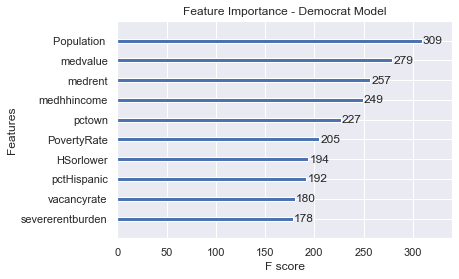

In [51]:
plot_importance(XGB_classifier_dem, max_num_features = 10, title='Feature Importance - Democrat Model', grid='gain')
plt.show()

The order is a little different, but the top 4 features are the same as what we saw in the republican model, just in a different order.

In [52]:
#Getting the probability predictions:

In [53]:
dem_y_hat_XGB_proba = XGB_classifier_dem.predict_proba(X_dem_test)

In [54]:
print(dem_y_hat_XGB_proba)

[[0.7886023  0.21139771]
 [0.8591049  0.14089511]
 [0.8153608  0.18463919]
 ...
 [0.7743144  0.2256856 ]
 [0.9627615  0.0372385 ]
 [0.93976784 0.06023215]]


In [55]:
df_dem_test = pd.DataFrame(X_dem_test).copy()
df_dem_test['Designated_OZ'] = y_dem_test
df_dem_test['prob_0'] = dem_y_hat_XGB_proba[:,0] 
df_dem_test['prob_1'] = dem_y_hat_XGB_proba[:,1]
df_dem_test['Model_Designated_OZ'] = dem_y_hat_XGB

In [56]:
df_dem_test.shape

(3584, 85)

In [57]:
df_dem_test.head()

,Type,SE_Flag,Population,medhhincome,PovertyRate,unemprate,medvalue,medrent,pctown,severerentburden,...,dec_score_5.0,dec_score_6.0,dec_score_7.0,dec_score_8.0,dec_score_9.0,dec_score_10.0,Designated_OZ,prob_0,prob_1,Model_Designated_OZ
12573,0,0,4186,34669,0.26,0.18,164900,1068,0.42,0.45,...,1,0,0,0,0,0,0,0.788602,0.211398,0
11905,0,0,4294,50882,0.15,0.04,389800,1538,0.34,0.37,...,0,0,0,0,1,0,0,0.859105,0.140895,0
25222,0,0,2246,69063,0.09,0.11,583700,1378,0.42,0.27,...,0,0,1,0,0,0,0,0.815361,0.184639,0
10230,0,0,4581,30098,0.45,0.09,270800,1030,0.20,0.39,...,0,0,0,0,0,1,0,0.589083,0.410917,0
24808,0,0,2314,29896,0.38,0.15,57900,702,0.62,0.29,...,0,0,0,0,0,0,1,0.716808,0.283192,0


In [282]:
df_dem_test.to_csv('Dem_Model_Test.csv')

## **<font color='pink'>Synthetic Democrats: Running the Democrat Model on Republican State's Data</font>**

In [58]:
synthdem_y_hat_XGB = XGB_classifier_dem.predict(X_repub)

In [59]:
np.round(XGB_classifier_dem.score(X_repub, y_repub),4)

0.7243

In [63]:
print('XGB f1 = {}'.format(f1_score(y_repub, synthdem_y_hat_XGB)))

XGB f1 = 0.2802697156259162


In [64]:
#Getting the probability predictions:

In [65]:
synth_demXGB_proba = XGB_classifier_dem.predict_proba(X_repub)

In [66]:
print(synth_demXGB_proba)

[[0.9280336  0.0719664 ]
 [0.753684   0.24631602]
 [0.8748722  0.1251278 ]
 ...
 [0.8164549  0.18354514]
 [0.31131178 0.6886882 ]
 [0.96865106 0.03134895]]


In [67]:
df_synth_demXGB_test = pd.DataFrame(X_repub).copy()
df_synth_demXGB_test['Designated_OZ'] = y_repub
df_synth_demXGB_test['prob_0'] = synth_demXGB_proba[:,0] 
df_synth_demXGB_test['prob_1'] = synth_demXGB_proba[:,1]
df_synth_demXGB_test['Model_Designated_OZ'] = synthdem_y_hat_XGB

In [68]:
df_synth_demXGB_test.shape

(17809, 85)

In [69]:
df_synth_demXGB_test.head()

,Type,SE_Flag,Population,medhhincome,PovertyRate,unemprate,medvalue,medrent,pctown,severerentburden,...,dec_score_5.0,dec_score_6.0,dec_score_7.0,dec_score_8.0,dec_score_9.0,dec_score_10.0,Designated_OZ,prob_0,prob_1,Model_Designated_OZ
2,0,0,20092,49930,0.17,0.12,125100,993,0.55,0.21,...,0,0,0,0,0,0,0,0.928034,0.071966,0
3,0,0,19834,36756,0.24,0.15,115600,1118,0.55,0.39,...,0,0,0,0,0,0,1,0.753684,0.246316,0
4,0,0,19187,43750,0.17,0.06,150600,1079,0.48,0.39,...,0,0,1,0,0,0,1,0.874872,0.125128,0
5,0,0,18273,54112,0.11,0.04,112200,920,0.41,0.13,...,0,0,0,0,1,0,0,0.755840,0.244160,0
6,0,0,17764,60333,0.17,0.09,209500,991,0.63,0.37,...,0,0,0,0,0,1,0,0.967573,0.032427,0


In [70]:
df_synth_demXGB_test.to_csv('Synth_Dem_Test_All_Repub_Data.csv')